**Library Version Information**

This notebook was created using a specific version of a key library. To ensure reproducibility, please use the following version:

*   **Library Name:** gepard
*   **Commit Hash:** `dd8be1422f6484dc0857c69157324948bc2b7db5`

IMPORT

In [1]:
import gepard as gp
from gepard.fits import th_KM15
import numpy as np
import mpmath as mp
import scipy.integrate as integrate
from time import perf_counter
from scipy.fft import idct
from scipy import special
import matplotlib.pyplot as plt
mp.dps = 1000
import os
import subprocess
import torch
import time
import pickle

KM15

CHANGE TO MASTER

In [2]:
import git
import os

# --- Configuration ---
repo_path = r'C:\Users\misla\cloned_repos\git-project-gepard'
branch_to_switch_to = "master"

print(f"Opening repository at '{repo_path}'...")

try:
    # 1. Create a Repo object from the existing cloned directory
    repo = git.Repo(repo_path)
    
    # --- NEW STEPS ---
    
    # 2. First, fetch all the latest information from the remote (GitHub)
    # This updates your local "phone book" of remote branches.
    print("Fetching latest data from remote 'origin'...")
    repo.remotes.origin.fetch()
    
    # 3. Now, use the direct git command to switch.
    # This is the most reliable way as it mimics the command line behavior.
    # Git will automatically create the local 'torch' branch to track 'origin/torch'.
    print(f"Attempting to switch to branch '{branch_to_switch_to}'...")
    repo.git.switch(branch_to_switch_to)
    
    # --- END NEW STEPS ---
    
    print("Switch successful!")
    print(f"Current active branch is now: {repo.active_branch}")

except git.exc.GitCommandError as e:
    print("\n--- GIT COMMAND ERROR ---")
    print(f"Failed to run git command: {e.command}")
    print(f"Error message from Git:\n{e.stderr.strip()}")
    print("\nThis might mean the branch does not exist even on the remote, or you have uncommitted changes.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Opening repository at 'C:\Users\misla\cloned_repos\git-project-gepard'...
Fetching latest data from remote 'origin'...
Attempting to switch to branch 'master'...
Switch successful!
Current active branch is now: master


DEFINING FUNCTIONS FOR KM15

In [3]:
def KM15Im(x,t1):
    return th_KM15.ImH(gp.DataPoint(xi=x, t=t1, Q2=4.))
def KM15Re(x,t1):
    return th_KM15.ReH(gp.DataPoint(xi=x, t=t1, Q2=4.))

def integratsing(x,x1,t1):
    if(x==x1):
        return (-1/mp.pi)*(th_KM15.ImH(gp.DataPoint(xi=x, t=t1, Q2=4.))*(1/(x1+x)))- mp.diff(lambda xi: KM15Im(xi,t1),x1)/mp.pi
    else:
        return (-1/mp.pi)*(th_KM15.ImH(gp.DataPoint(xi=x, t=t1, Q2=4.))*(1/(x1+x)))+(-1/mp.pi)*(th_KM15.ImH(gp.DataPoint(xi=x, t=t1, Q2=4.))-th_KM15.ImH(gp.DataPoint(xi=x1, t=t1, Q2=4.)))*(1/(x-x1))

def oduzeti_int(a,b,c,t1):
    return (-1/mp.pi)*th_KM15.ImH(gp.DataPoint(xi=c, t=t1, Q2=4.))*mp.ln((b-c)/(c-a))

SUPSTRACTION CONSTANT

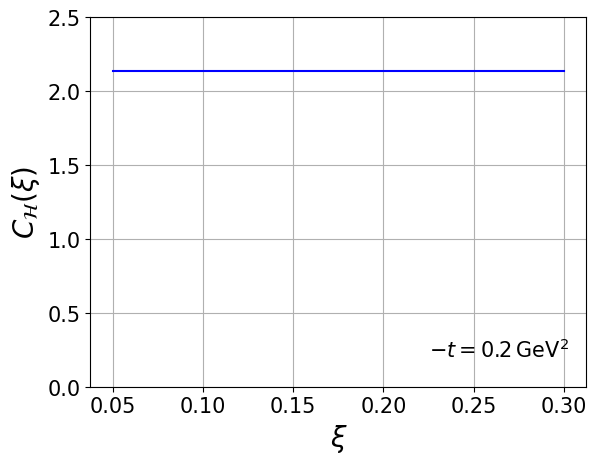

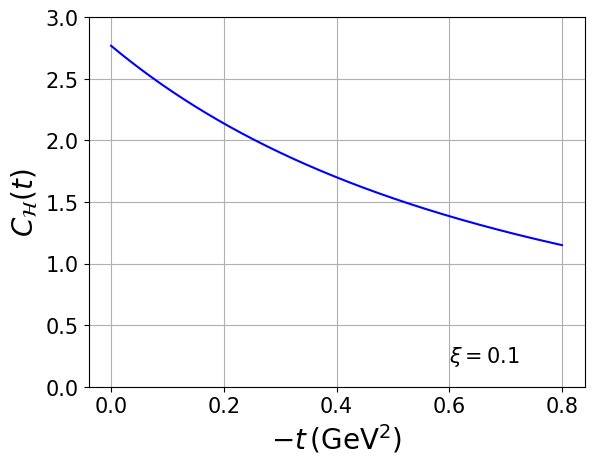

In [4]:
def clenshawKM15(xi1,t1,bot_lim1,spacing1,j):
    #points and weights for clenshaw curtis quadrature
    def cheb2nodes(n: int) -> np.ndarray:
        if n <= 1:
            return np.array([0.0]) if n == 1 else np.array([])
        return np.cos(np.arange(n) * np.pi / (n - 1))

    def curtis_nodes_weights(N):
        x = cheb2nodes(N)
        i = np.arange(2, N, 2)
        c_part = 2 / (1 - i**2)
        c = np.concatenate(([2], c_part))
        start_idx = (N // 2) - 1
        end_idx = 0 # The slice will go down to index 1.
        mirrored_part = c[start_idx:end_idx:-1]
        c = np.concatenate((c, mirrored_part))
        ws = np.real(np.fft.ifft(c))
        ws[0] /= 2
        ws = np.concatenate((ws, [ws[0]]))
        return(ws,x)
    curti=curtis_nodes_weights(j)
    #clenshaw curtis quadrature calculation

    def clenshaw(funk,a,b):
        weights=curti[0]
        nodes=curti[1]
        rez=0
        for i in range(len(weights)):
            rez+=((b-a)/2)*funk(((b-a)/2)*nodes[i]+(a+b)/2)*weights[i]
        return rez
        
    
    #subtraction constant calculation

    def C_H(xi,t,bot_lim,spacing):
        rezultat21=0
        rezultat21+=clenshaw(lambda x: integratsing(x,xi,t),bot_lim,spacing)
        rezultat21+=clenshaw(lambda x: integratsing(x,xi,t),spacing,xi-spacing)
        rezultat21+=clenshaw(lambda x: integratsing(x,xi,t),xi-spacing,xi+spacing)
        rezultat21+=clenshaw(lambda x: integratsing(x,xi,t),xi+spacing,1)
       
        return [rezultat21+oduzeti_int(0,1,xi,t)-KM15Re(xi,t),abs(rezultat21)]
    return C_H(xi1,t1,bot_lim1,spacing1)
#plotting the dependency on xi
x=np.linspace(0.05,0.3,1000)
y=[]
for i in x:
    y.append(clenshawKM15(i,-0.2,1e-16,1e-6,200)[0])
plt.plot(x,y,'b-')
plt.ylim(0,2.5)
plt.xlabel(r'$\xi$',fontsize=20)
plt.text(0.225,0.2, r'$-t=0.2 \,\mathrm{GeV}^2$',fontsize=15)
plt.ylabel(r'$C_{\mathcal{H}}(\xi)$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
#plt.savefig('clenshaw C(xi) KM15.png', bbox_inches='tight', dpi=300)
plt.show()
    
#plotting the dependency on t
x1=np.linspace(0,0.8,1000)
y1=[]
for j in x1:
    y1.append(clenshawKM15(0.1,-j,1e-16,1e-6,200)[0])
plt.plot(x1,y1,'b-')
plt.ylim(0,3)
plt.text(0.6,0.2, r'$\xi=0.1$',fontsize=15)
plt.xlabel(r'$-t \,(\mathrm{GeV}^2)$',fontsize=20)
plt.ylabel(r'$C_{\mathcal{H}}(t)$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
#plt.savefig('clenshaw C(t) KM15.png', bbox_inches='tight', dpi=300)
plt.show()


PRESSURE

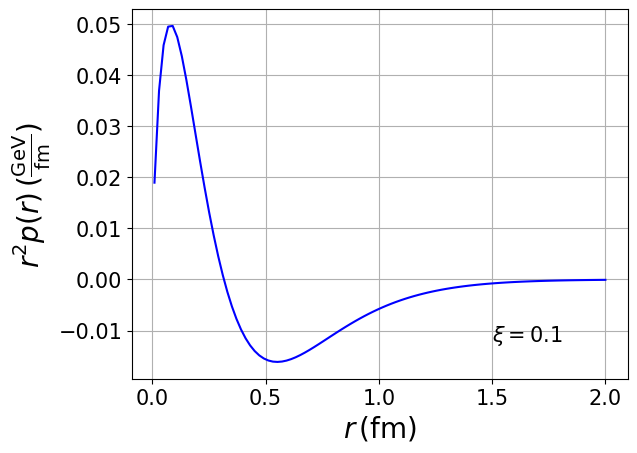

In [6]:
#definition of Deff
def Deff(t):
    return -1.673847983974/((1-(t/(1.149107433579**2)))**1.864750656837)
#definition of the integrand
def integraltlakeff(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Deff(x)
#integration of the expression for pressure
def tlakeff(r):
    return mp.quadosc(lambda x: integraltlakeff(r,-x),[0,mp.inf],zeros= lambda n: (mp.pi*n/r)**2)

radijus=np.linspace(0.01,2,100)
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakeff(i/0.198))
plt.plot(radijus,tlakk,'b-')
plt.ylabel(r'$r^2p(r) \,(\frac{\mathrm{GeV}}{\mathrm{fm}})$',fontsize=20)
plt.xlabel(r'$r \,(\mathrm{fm})$',fontsize=20)
plt.text(1.5,-0.012,r'$\xi=0.1$',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
#plt.savefig('KM15 pressure.png', bbox_inches='tight', dpi=300)
plt.show()

C15-2

CHANGE TO TORCH

In [2]:
import git

# --- Configuration ---
repo_path = r'C:\Users\misla\cloned_repos\git-project-gepard' # IMPORTANT: Change this to your actual path
branch_to_switch_to = "torch"

print(f"Attempting to switch to branch '{branch_to_switch_to}' in repository at '{repo_path}'...")

try:
    # 1. Create a Repo object from the existing cloned directory
    repo = git.Repo(repo_path)
    
    # 2. Check if the branch exists before trying to switch
    if branch_to_switch_to in repo.branches:
        # 3. Get the branch object and "checkout" (which is GitPython's way of switching)
        print(f"Branch '{branch_to_switch_to}' found. Switching...")
        repo.branches[branch_to_switch_to].checkout()
        
        print("Switch successful!")
        # You can easily verify the active branch
        print(f"Current active branch is now: {repo.active_branch}")
    else:
        print(f"Error: Branch '{branch_to_switch_to}' does not exist in the repository.")
        print(f"Available branches are: {[b.name for b in repo.branches]}")

except git.exc.GitCommandError as e:
    print("Error: Failed to switch branches due to a Git command error.")
    # This often happens if you have uncommitted changes in your current branch.
    print(f"Stderr: {e.stderr.strip()}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Attempting to switch to branch 'torch' in repository at 'C:\Users\misla\cloned_repos\git-project-gepard'...
Branch 'torch' found. Switching...
Switch successful!
Current active branch is now: torch


FUNCTION DEFINING FOR NEURAL NETWORK

In [5]:
class NN(gp.model.NeuralModel, gp.eff.DipoleEFF, gp.dvcs.BMK):    
    pass
thn = NN(output_layer=['ImH', 'ReH'])
thn.name = 'C15-2'
thn.nets += torch.load('C15-2.tar', weights_only=False)
def KM15Impros(xa,t1a):
    return thn.predict(gp.DataPoint(xB=2*np.float64(xa)/(1+np.float64(xa)), t=t1a), observable='ImH')
def KM15Repros(xb,t1b):
    return thn.predict(gp.DataPoint(xB=2*np.float64(xb)/(1+np.float64(xb)), t=t1b), observable='ReH')
    
def integratsingpros(xie,xi1e,t1e):
    CFF=thn.predict(gp.DataPoint(xB=2*np.float64(xie)/(1+np.float64(xie)), t=t1e), observable='ImH')
    if(xie==xi1e):
        return (-1/np.pi)*(CFF*(1/(xi1e+xie)))- mp.diff(lambda xe: KM15Impros(np.float64(xe),t1e),xi1e)/np.pi
    else:
        return (-1/np.pi)*(CFF*(1/(xi1e+xie)))+(-1/np.pi)*(CFF-thn.predict(gp.DataPoint(xB=2*xi1e/(1+xi1e), t=t1e), observable='ImH'))*(1/(xie-xi1e))

def oduzeti_intpros(a,b,c,t1f):
    return (-1/mp.pi)*thn.predict(gp.DataPoint(xB=2*c/(1+c), t=t1f), observable='ImH')*mp.ln((b-c)/(c-a))

def KM15Impoj(xa1,t1a1,broj11):
    return thn.predict(gp.DataPoint(xB=2*np.float64(xa1)/(1+np.float64(xa1)), t=t1a1), observable='ImH',mesh=True)[broj11]
def KM15Repoj(xb1,t1b1,broj21):
    return thn.predict(gp.DataPoint(xB=2*np.float64(xb1)/(1+np.float64(xb1)), t=t1b1), observable='ReH',mesh=True)[broj21]

def integratsingpoj(xie1,xi1e1,t1e1,broj31):
    CFF=thn.predict(gp.DataPoint(xB=2*np.float64(xie1)/(1+np.float64(xie1)), t=t1e1), observable='ImH',mesh=True)[broj31]
    if(xie1==xi1e1):
        return (-1/np.pi)*(CFF*(1/(xi1e1+xie1)))- mp.diff(lambda xe: KM15Impoj(np.float64(xe),t1e1,broj31),xi1e1)/np.pi
    else:
        return (-1/np.pi)*(CFF*(1/(xi1e1+xie1)))+(-1/np.pi)*(CFF-thn.predict(gp.DataPoint(xB=2*xi1e1/(1+xi1e1), t=t1e1), observable='ImH',mesh=True)[broj31])*(1/(xie1-xi1e1))
def oduzeti_intpoj(a1,b1,c1,t1f1,broj41):
    return (-1/mp.pi)*thn.predict(gp.DataPoint(xB=2*c1/(1+c1), t=t1f1), observable='ImH',mesh=True)[broj41]*mp.ln((b1-c1)/(c1-a1))



SUPSTRACTION CONSTANT AND THE D-TERM

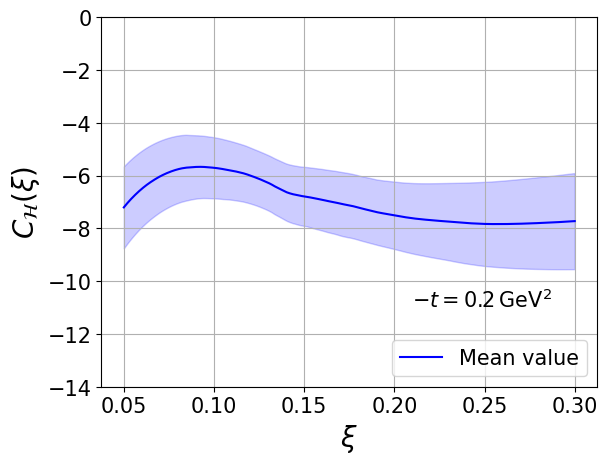

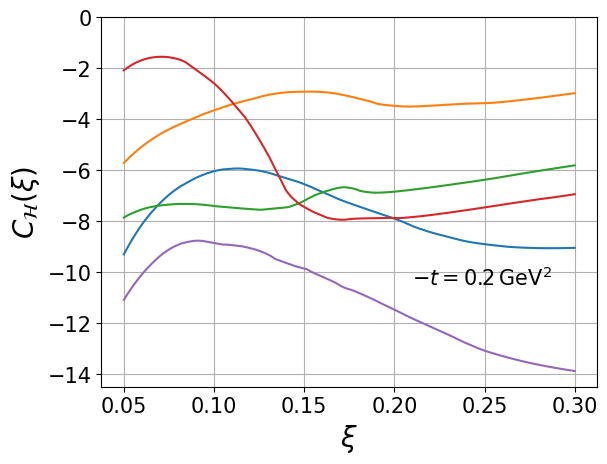

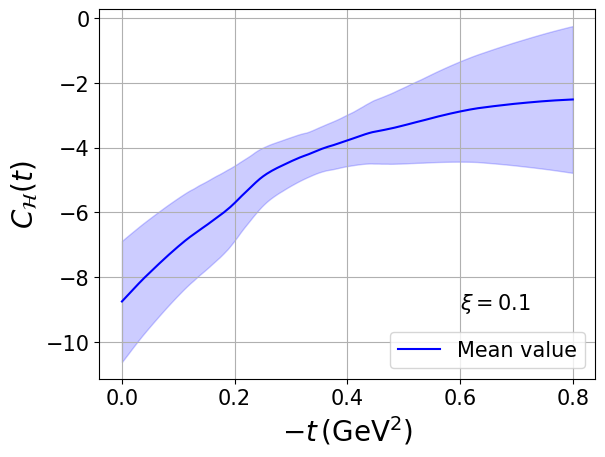

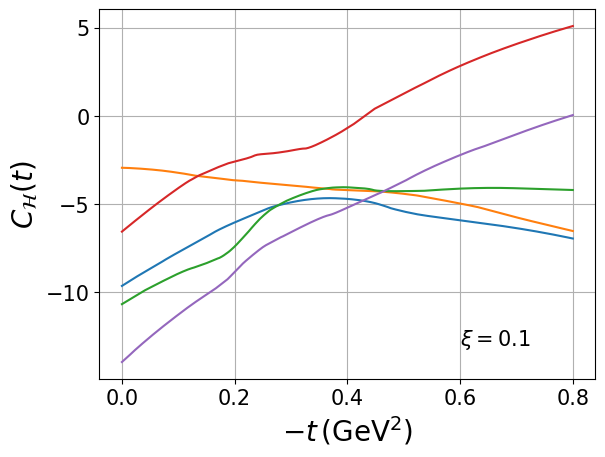

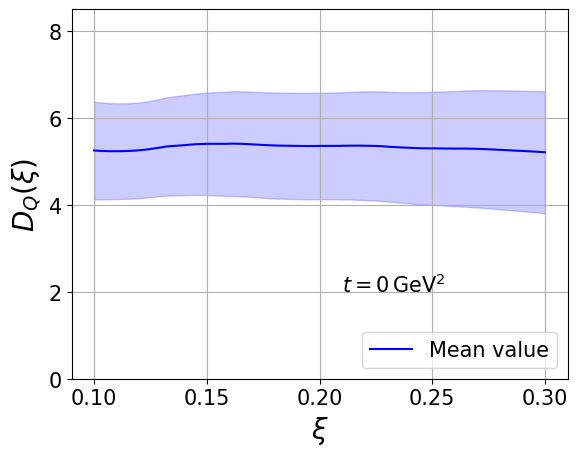

In [7]:
def clenshawpros():
    # calculation of clenshaw-curtis points and weights
    def cheb2nodes(n: int) -> np.ndarray:
        if n <= 1:
            return np.array([0.0]) if n == 1 else np.array([])
        return np.cos(np.arange(n) * np.pi / (n - 1))

    def curtis_nodes_weights(N):
        x = cheb2nodes(N)
        i = np.arange(2, N, 2)
        c_part = 2 / (1 - i**2)
        c = np.concatenate(([2], c_part))
        start_idx = (N // 2) - 1
        end_idx = 0 # The slice will go down to index 1.
        mirrored_part = c[start_idx:end_idx:-1]
        c = np.concatenate((c, mirrored_part))
        ws = np.real(np.fft.ifft(c))
        ws[0] /= 2
        ws = np.concatenate((ws, [ws[0]]))
        return(ws,x)
    curti=curtis_nodes_weights(200)
    #calculation of clenshaw-curtis quadrature

    def clenshaw(funk,a,b):
        weights=curti[0]
        nodes=curti[1]
        rez=0
        for i in range(len(weights)):
            rez+=((b-a)/2)*funk(((b-a)/2)*nodes[i]+(a+b)/2)*weights[i]
        return rez

    #calculation of the average subtraction constant
    def C_tpros(xi,t,epsa,epsb):
        rezultat2=0
        rezultat2+=clenshaw(lambda x: integratsingpros(x,xi,t),epsa,epsb)
        rezultat2+=clenshaw(lambda x: integratsingpros(x,xi,t),epsb,xi-epsb)
        rezultat2+=clenshaw(lambda x: integratsingpros(x,xi,t),xi-epsb,xi+epsb)
        rezultat2+=clenshaw(lambda x: integratsingpros(x,xi,t),xi+epsb,1)
        return rezultat2+oduzeti_intpros(0,1,xi,t)-KM15Repros(xi,t)
    #calculation of the individual subtraction constant
    def C_tpoj(xi,t,epsa,epsb,broj):
        rezultat2=0
        rezultat2+=clenshaw(lambda x: integratsingpoj(x,xi,t,broj),epsa,epsb)
        rezultat2+=clenshaw(lambda x: integratsingpoj(x,xi,t,broj),epsb,xi-epsb)
        rezultat2+=clenshaw(lambda x: integratsingpoj(x,xi,t,broj),xi-epsb,xi+epsb)
        rezultat2+=clenshaw(lambda x: integratsingpoj(x,xi,t,broj),xi+epsb,1)
        return rezultat2+oduzeti_intpoj(0,1,xi,t,broj)-KM15Repoj(xi,t,broj)


    # calculation for the dependency on xi
    xa=np.linspace(0.05,0.3,1000)
    ya=[]
    for i in xa:
        ya.append(C_tpros(i,-0.2,0,1e-6))
    ya1=[]
    for i in xa:
        ya1.append(C_tpoj(i,-0.2,0,1e-6,0))
    ya2=[]
    for i in xa:
        ya2.append(C_tpoj(i,-0.2,0,1e-6,1))
    ya3=[]
    for i in xa:
        ya3.append(C_tpoj(i,-0.2,0,1e-6,2))
    ya4=[]
    for i in xa:
        ya4.append(C_tpoj(i,-0.2,0,1e-6,3))
    ya5=[]
    for i in xa:
        ya5.append(C_tpoj(i,-0.2,0,1e-6,4))
   #creating the error band
    yan=[]
    for i in range(len(xa)):
        varijanca=0
        varijanca+=(ya1[i]-ya[i])**2+(ya2[i]-ya[i])**2+(ya3[i]-ya[i])**2+(ya4[i]-ya[i])**2+(ya5[i]-ya[i])**2
        yan.append(np.sqrt(varijanca/20))
    yap=np.array(ya, dtype=float)
    yae=np.array(yan, dtype=float)
    
    #plotting the average dependency on xi
    plt.plot(xa,yap,'b-',label='Mean value')
    plt.ylim(-14,0)
    plt.fill_between(xa,yap-yae,yap+yae,color='blue',alpha=0.2)
    plt.xlabel(r'$\xi$',fontsize=20)
    plt.text(0.21,-11, r'$-t=0.2 \,\mathrm{GeV}^2$',fontsize=15)
    plt.ylabel(r'$C_{\mathcal{H}}(\xi)$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(fontsize=15,loc='lower right')
    plt.grid(True)
    #plt.savefig('clenshaw C(xi) avg.png', bbox_inches='tight', dpi=300)
    plt.show()

    #plotting the individual dependency on xi
    plt.plot(xa,ya1)
    plt.plot(xa,ya2)
    plt.plot(xa,ya3)
    plt.plot(xa,ya4)
    plt.plot(xa,ya5)
    plt.ylim(top=0)
    plt.xlabel(r'$\xi$',fontsize=20)
    plt.text(0.21,-10.5, r'$-t=0.2 \,\mathrm{GeV}^2$',fontsize=15)
    plt.ylabel(r'$C_{\mathcal{H}}(\xi)$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    #plt.savefig('clenshaw C(xi) ind.png', bbox_inches='tight', dpi=300)
    plt.show()

    #calculation for the dependency on t
    xb=np.linspace(0,0.8,1000)
    yb=[]
    for j in xb:
        yb.append(C_tpros(0.1,-j,0,1e-6))

    yb1=[]
    for j in xb:
        yb1.append(C_tpoj(0.1,-j,0,1e-6,0))
    yb2=[]
    for j in xb:
        yb2.append(C_tpoj(0.1,-j,0,1e-6,1))
    yb3=[]
    for j in xb:
        yb3.append(C_tpoj(0.1,-j,0,1e-6,2))
    yb4=[]
    for j in xb:
        yb4.append(C_tpoj(0.1,-j,0,1e-6,3))
    yb5=[]
    for j in xb:
        yb5.append(C_tpoj(0.1,-j,0,1e-6,4))
    #creating the error band
    ybn=[]
    for i in range(len(xb)):
        varijanca=0
        varijanca+=(yb1[i]-yb[i])**2+(yb2[i]-yb[i])**2+(yb3[i]-yb[i])**2+(yb4[i]-yb[i])**2+(yb5[i]-yb[i])**2
        ybn.append(np.sqrt(varijanca/20))
    ybp=np.array(yb, dtype=float)
    ybe=np.array(ybn, dtype=float)
    #plotting the average dependency on t
    plt.plot(xb,yb,'b-',label='Mean value')
    #plt.ylim(top=0)
    plt.fill_between(xb,ybp-ybe,ybp+ybe,color='blue',alpha=0.2)
    plt.text(0.6,-9, r'$\xi=0.1$',fontsize=15)
    plt.xlabel(r'$-t \,(\mathrm{GeV}^2)$',fontsize=20)
    plt.ylabel(r'$C_{\mathcal{H}}(t)$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(fontsize=15,loc='lower right')
    plt.grid(True)
    #plt.savefig('clenshaw C(t) avg.png', bbox_inches='tight', dpi=300)
    plt.show()

    #plotting the individual dependency on t
    plt.plot(xb,yb1)
    plt.plot(xb,yb2)
    plt.plot(xb,yb3)
    plt.plot(xb,yb4)
    plt.plot(xb,yb5)
    #plt.ylim(top=0)
    plt.xlabel(r'$-t \,(\mathrm{GeV}^2)$',fontsize=20)
    plt.text(0.6,-13, r'$\xi=0.1$',fontsize=15)
    plt.ylabel(r'$C_{\mathcal{H}}(t)$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    #plt.savefig('clenshaw C(t) ind.png', bbox_inches='tight', dpi=300)
    plt.show()

    #calculation of the D-term dependency on xi
    xa=np.linspace(0.1,0.3,100)
    ya=[]
    for i in xa:
        ya.append(-(3/5)*C_tpros(i,0,0,1e-6))
    ya1=[]
    for i in xa:
        ya1.append(-(3/5)*C_tpoj(i,0,0,1e-6,0))
    ya2=[]
    for i in xa:
        ya2.append(-(3/5)*C_tpoj(i,0,0,1e-6,1))
    ya3=[]
    for i in xa:
        ya3.append(-(3/5)*C_tpoj(i,0,0,1e-6,2))
    ya4=[]
    for i in xa:
        ya4.append(-(3/5)*C_tpoj(i,0,0,1e-6,3))
    ya5=[]
    for i in xa:
        ya5.append(-(3/5)*C_tpoj(i,0,0,1e-6,4))
    #creating the error band
    yan=[]
    for i in range(len(xa)):
        varijanca=0
        varijanca+=(ya1[i]-ya[i])**2+(ya2[i]-ya[i])**2+(ya3[i]-ya[i])**2+(ya4[i]-ya[i])**2+(ya5[i]-ya[i])**2
        yan.append(np.sqrt(varijanca/20))
    yap=np.array(ya, dtype=float)
    yae=np.array(yan, dtype=float)
    #plotting the D-term dependency on xi
    plt.plot(xa,yap,'b-',label='Mean value')
    plt.ylim(0,8.5)
    plt.fill_between(xa,yap-yae,yap+yae,color='blue',alpha=0.2)
    plt.xlabel(r'$\xi$',fontsize=20)
    plt.text(0.21,2, r'$t=0 \,\mathrm{GeV}^2$',fontsize=15)
    plt.ylabel(r'$D_{Q}(\xi)$',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(fontsize=15,loc='lower right')
    plt.grid(True)
    #plt.savefig('C15-2 D_Q(0).png', bbox_inches='tight', dpi=300)
    plt.show()


    return
clenshawpros()

PRESSURE

In [8]:
#definitions of Deff for various xi from xi=0.1 to xi=0.3 with increments of 0.04
def Def(t):
    return 5.294994839145/((1-(t/1.558535623675**2))**5.693844233198)
def Def1(t):
    return 5.533008940063/((1-(t/235.0272265517**2))**103464.2496198)
def Def2(t):
    return 5.574110699836/((1-(t/234.882247808**2))**76575.14750207)
def Def3(t):
    return 5.479037293055/((1-(t/221.0154372273**2))**45597.88421496)
def Def4(t):
    return 5.427609700064/((1-(t/217.72155279781**2))**36935.57453018)
def Def5(t):
    return 5.310901746249/((1-(t/194.8960597062**2))**26974.09990363)
#definitions of Deff for different neural networks
def Defpoj1(t):
    return 5.995392900223/((1-(t/0.4756775552036**2))**0.7771188682799)
def Defpoj2(t):
    return 1.70194034168/((1-(t/0.4923842554691**2))**-0.4068755016299)
def Defpoj3(t):
    return 6.775250163328/((1-(t/144.1747793163**2))**52991.11169413)
def Defpoj4(t):
    return 3.983367294384/((1-(t/236.259521798**2))**263632.2571462)
def Defpoj5(t):
    return 8.58970698175/((1-(t/188.8553633926**2))**90030.36141275)


#definitions of the integrand for various xi from xi=0.1 to xi=0.3 with increments of 0.04
def integraltlakef(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def(x)
def integraltlakef1(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def1(x)
def integraltlakef2(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def2(x)
def integraltlakef3(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def3(x)
def integraltlakef4(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def4(x)
def integraltlakef5(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Def5(x)
#definitions of the integrand for different neural networks
def integraltlakefpoj1(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Defpoj1(x)
def integraltlakefpoj2(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Defpoj2(x)
def integraltlakefpoj3(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Defpoj3(x)
def integraltlakefpoj4(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Defpoj4(x)
def integraltlakefpoj5(r,x):
    return (x*mp.sin(r*mp.sqrt(-x))/r)*Defpoj5(x)
#definitions of pressure for various xi from xi=0.1 to xi=0.3 with increments of 0.04
def tlakef(r):
    return mp.quad(lambda x: integraltlakef(r,-x),[0,mp.inf])
def tlakef1(r):
    return mp.quad(lambda x: integraltlakef1(r,-x),[0,mp.inf])
def tlakef2(r):
    return mp.quad(lambda x: integraltlakef2(r,-x),[0,mp.inf])
def tlakef3(r):
    return mp.quad(lambda x: integraltlakef3(r,-x),[0,mp.inf])
def tlakef4(r):
    return mp.quad(lambda x: integraltlakef4(r,-x),[0,mp.inf])
def tlakef5(r):
    return mp.quad(lambda x: integraltlakef5(r,-x),[0,mp.inf])
#definitions of pressure for different neural networks
def tlakefpoj1(r):
    return mp.quadosc(lambda x: integraltlakefpoj1(r,-x),[0,mp.inf],zeros=lambda n: (mp.pi*n/r)**2)
def tlakefpoj2(r):
    return mp.quadosc(lambda x: integraltlakefpoj2(r,-x),[0,mp.inf],zeros=lambda n: (mp.pi*n/r)**2)
def tlakefpoj3(r):
    return mp.quad(lambda x: integraltlakefpoj3(r,-x),[0,mp.inf])
def tlakefpoj4(r):
    return mp.quad(lambda x: integraltlakefpoj4(r,-x),[0,mp.inf])
def tlakefpoj5(r):
    return mp.quad(lambda x: integraltlakefpoj5(r,-x),[0,mp.inf])

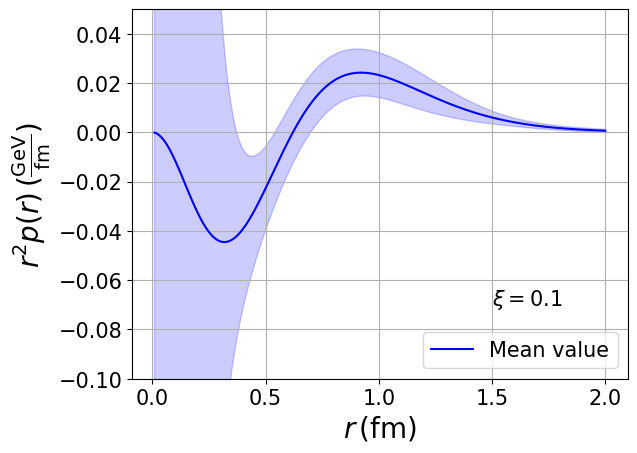

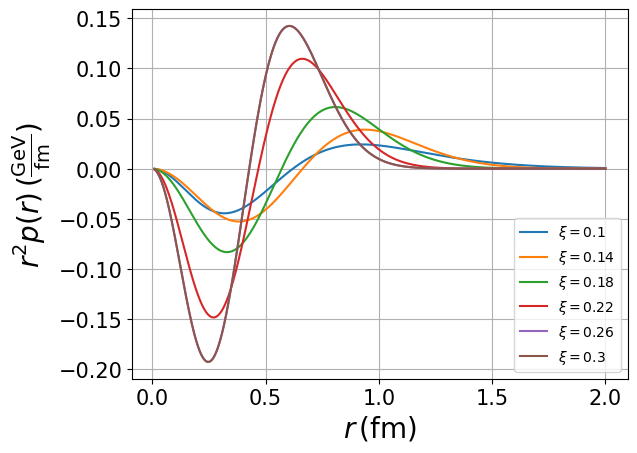

In [9]:
# pressure calculation for different neural networks
radijus=np.linspace(0.01,2,1000)
tlakkpros=[]
tlakkpros1=[]
for i in radijus:
    tlakkpros.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef(i/0.198))
tlakkpoj1=[]
for i in radijus:
    tlakkpoj1.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakefpoj1(i/0.198))
tlakkpoj2=[]
for i in radijus:
    tlakkpoj2.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakefpoj2(i/0.198))
tlakkpoj3=[]
for i in radijus:
    tlakkpoj3.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakefpoj3(i/0.198))
tlakkpoj4=[]
for i in radijus:
    tlakkpoj4.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakefpoj4(i/0.198))
tlakkpoj5=[]
for i in radijus:
    tlakkpoj5.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakefpoj5(i/0.198))
#creating the error band
ybn=[]
for i in range(len(radijus)):
    brojač=0
    brojač+=(tlakkpoj1[i]-tlakkpros[i])**2+(tlakkpoj2[i]-tlakkpros[i])**2+(tlakkpoj3[i]-tlakkpros[i])**2+(tlakkpoj4[i]-tlakkpros[i])**2+(tlakkpoj5[i]-tlakkpros[i])**2
    ybn.append(np.sqrt(brojač/20))
ybp=np.array(tlakkpros, dtype=float)
ybe=np.array(ybn, dtype=float)
#plotting the average pressure and the error band
plt.plot(radijus,tlakkpros,'b-',label='Mean value')
plt.fill_between(radijus,ybp-ybe,ybp+ybe,color='blue',alpha=0.2)
plt.legend(fontsize=15,loc='lower right')
plt.ylabel(r'$r^2p(r) \,(\frac{\mathrm{GeV}}{\mathrm{fm}})$',fontsize=20)
plt.xlabel(r'$r \,(\mathrm{fm})$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.ylim(-0.1, 0.05)
plt.text(1.5,-0.07,r'$\xi=0.1$',fontsize=15)
#plt.savefig('C15-2 pressure average with band.png', bbox_inches='tight', dpi=300)
plt.show()

# pressure calculation for various xi from xi=0.1 to xi=0.3 with increments of 0.04 and plotting
radijus=np.linspace(0.01,2,1000)
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.1$')
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef1(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.14$')
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef2(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.18$')
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef3(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.22$')
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef4(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.26$')
tlakk=[]
for i in radijus:
    tlakk.append(((i/0.198)**2/0.198)*(1/(24*np.pi**2*0.938))*tlakef4(i/0.198))
plt.plot(radijus,tlakk,label=r'$\xi=0.3$')

plt.ylabel(r'$r^2p(r) \,(\frac{\mathrm{GeV}}{\mathrm{fm}})$',fontsize=20)
plt.xlabel(r'$r \,(\mathrm{fm})$',fontsize=20)
#plt.text(1.5,-0.035,r'$\xi=0.1$',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend()
#plt.savefig('C15-2 pressures various xi.png', bbox_inches='tight', dpi=300)
plt.show()